 <font size="+2"><p style="text-align: center;"><b> Auswertung Versuch 211 PAP 2.1. </p></font>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2
from scipy.signal import argrelextrema
from scipy.integrate import quad
from numpy import exp, sqrt, pi, array, mean
from uncertainties import ufloat, unumpy as unp
from uncertainties import umath

In [2]:
def chi_2(func, fit, x, y, yerr, name = ''):
    chi_sq = np.sum((func(x, *fit) - y)**2 / yerr **2)
    dof = len(y) - len(fit)
    chi_sq_red = chi_sq / dof
    prob = round(1 - chi2.cdf(chi_sq, dof), 3) * 1e2
    if name == '':
        print('chi_sq = ' + str(chi_sq), 'chi_sq_red = ' + str(chi_sq_red), 
              'Fitwahrscheinlichkeit = ' + str(prob))
    else:
        print(name, 'chi_sq = ' + str(chi_sq), 'chi_sq_red = ' + str(chi_sq_red), 
              'Fitwahrscheinlichkeit = ' + str(prob))
    return np.array([chi_sq, chi_sq_red, prob])

def perr(pcov):
    return np.sqrt(np.diag(pcov))

def uprint(name, value, error, unit = ''):
    print(name + str(ufloat(value, error)) + ' ' + unit)
    return np.array([ufloat(value, error)])

def fiterr(func, x, popt, pcov):
    plt.fill_between(x, func(x, *(popt - perr(pcov))), func(x, *(popt + perr(pcov))))
    
def dmean(param, err):
    return sqrt(np.var(param) / len(param) + np.sum(err * err) / len(err)**2)

In [3]:
def gau(x, A, mu, sig):
    return y0 + A / (sqrt(2*pi) * sig) * exp(- (x-mu)**2 / 2 / sig**2)

def poisson(x, A_p, mu_p):
    return A_p * exp(-mu_p) * mu_p**2 / gamma(x+1)

def binomial(n, k, p):
    return fctl(n) / (fctl(n-k) * fctl(k)) * (p **k) * ((1-p) **(n-k))

def lin(x, a, b):
    return x * a + b

def prop(x, a):
    return x * a

def twoexp(x, A1, l1, A2, l2):
    return A1 * np.exp(-x*l1) + A2 * np.exp(-x*l2)

def oneexp(x, A, l):
    return A * np.exp(-x*l)

def staterr(n, t):
    return np.sqrt(n / t)    

In [4]:
# Für Diagramme etc
diagrammzahl = 7 # Nummer des ersten geplotteten Diagramms

l = array([[15.5, 25.5, 40.5], [0.1, 0.1, 0.1]]) * 1e-2 # m
fsy = array([[.615, .615, .604], [.005, .005, .005]]) # Hz
fasy = array([[.633, .664, .738], [.005, .006, .005]]) # Hz
fu = array([[.615, .615, .616], [.004, .005, .005]]) # Hz
fv = array([[.632, .664, .737], [.004, .005, .006]]) # Hz

## 3.1 Berechnung der Frequenzen der reinen und gemischten Schwingungsformen 

In [5]:
wsy = 2*pi * fsy
wasy = 2*pi * fasy
wu = 2*pi * fu
wv = 2*pi * fv
wp = array([fv[0] + fu[0], sqrt(fu[1]**2 + fv[1]**2)]) * pi
ws = array([fv[0] - fu[0], sqrt(fu[1]**2 + fv[1]**2)]) * pi

print('aus den Messwerten für die Eigenfrequenzen ermittelte Werte:')

for i in range(3):
    print('Kopplung l = {}m: '.format(np.round(l[0,i], 3)))
    uprint('w_sy = ', wsy[0,i], wsy[1, i], '1/s')
    uprint('w_asy = ', wasy[0,i], wasy[1, i], '1/s')
    uprint('w_p = ', wp[0,i], wp[1, i], '1/s')
    uprint('w_s = ', ws[0,i], ws[1, i], '1/s')

aus den Messwerten für die Eigenfrequenzen ermittelte Werte:
Kopplung l = 0.155m: 
w_sy = 3.864+/-0.031 1/s
w_asy = 3.977+/-0.031 1/s
w_p = 3.918+/-0.018 1/s
w_s = 0.053+/-0.018 1/s
Kopplung l = 0.255m: 
w_sy = 3.864+/-0.031 1/s
w_asy = 4.17+/-0.04 1/s
w_p = 4.018+/-0.022 1/s
w_s = 0.154+/-0.022 1/s
Kopplung l = 0.405m: 
w_sy = 3.795+/-0.031 1/s
w_asy = 4.637+/-0.031 1/s
w_p = 4.251+/-0.025 1/s
w_s = 0.380+/-0.025 1/s


In [6]:
# erwartete Werte für die Schwebung
wptheo = array([fasy[0] + fsy[0], sqrt(fasy[1]**2 + fsy[1]**2)]) * pi
wstheo = array([fasy[0] - fsy[0], sqrt(fasy[1]**2 + fsy[1]**2)]) * pi

print('theoretisch erwartete Werte')

for i in range(3):
    print('Kopplung l = {}m: '.format(np.round(l[0,i], 3)))
    uprint('w_p,theo = ', wptheo[0,i], wptheo[1, i], '1/s')
    uprint('w_s,theo = ', wstheo[0,i], wstheo[1, i], '1/s')

theoretisch erwartete Werte
Kopplung l = 0.155m: 
w_p,theo = 3.921+/-0.022 1/s
w_s,theo = 0.057+/-0.022 1/s
Kopplung l = 0.255m: 
w_p,theo = 4.018+/-0.025 1/s
w_s,theo = 0.154+/-0.025 1/s
Kopplung l = 0.405m: 
w_p,theo = 4.216+/-0.022 1/s
w_s,theo = 0.421+/-0.022 1/s


## 3.2 Berechnung der Kopplungsgrade aus den Kreisfrequenzen

In [7]:
kappa = array([(wv[0]**2 - wu[0]**2) / (2 * wu[0]**2), 
               (wv[0] / wu[0])**2 * sqrt((wv[1] / wv[0])**2 + (wu[1] / wu[0])**2)])

kappatheo = array([(wasy[0]**2 - wsy[0]**2) / (2 * wsy[0]**2), 
               (wasy[0] / wsy[0])**2 * sqrt((wasy[1] / wasy[0])**2 + (wsy[1] / wsy[0])**2)])

print('Kopplungsgrade (genähert)')

for i in range(3):
    print('Kopplung l = {}m: '.format(np.round(l[0,i], 3)))
    uprint('kappa = ', kappa[0,i], kappa[1,i])
    uprint('kappa_theo = ', kappatheo[0,i], kappatheo[1,i])

Kopplungsgrade (genähert)
Kopplung l = 0.155m: 
kappa = 0.028+/-0.010 
kappa_theo = 0.030+/-0.012 
Kopplung l = 0.255m: 
kappa = 0.083+/-0.013 
kappa_theo = 0.083+/-0.014 
Kopplung l = 0.405m: 
kappa = 0.216+/-0.016 
kappa_theo = 0.246+/-0.016 


#### Berechnung der Verhältnisse mit Nährung

In [8]:
vexp = np.zeros((2,3))
vtheo = np.zeros((2,3))
vausl = np.zeros((2,3))

for i in range(3):
    j = i+1;
    if (j == 3):
        j = 2
        i = 0
    vexp[0,i] = kappa[0,i]/kappa[0,j]
    vexp[1,i] = vexp[0,i] * sqrt((kappa[1,i]/kappa[0,i])**2 + (kappa[1,j]/kappa[0,j])**2)
    vtheo[0,i] = kappatheo[0,i]/kappatheo[0,j]
    vtheo[1,i] = vtheo[0,i] * sqrt((kappatheo[1,i]/kappatheo[0,i])**2 + (kappatheo[1,j]/kappatheo[0,j])**2)
    vausl[0,i] = (l[0,i]/l[0,j])**2
    vausl[1,i] = vausl[0,i] * sqrt((2*l[1,i]/l[0,i])**2 + (2*l[1,j]/l[0,j])**2)
    
    print('lambda_{},{}: '.format(i+1, j+1))
    uprint('aus Schwebung: ', vexp[0,i], vexp[1,i])
    uprint('aus Eigenschw: ', vtheo[0,i], vtheo[1,i])
    uprint('aus Längen: ', vausl[0,i], vausl[1,i])

lambda_1,2: 
aus Schwebung: 0.34+/-0.13 
aus Eigenschw: 0.36+/-0.16 
aus Längen: 0.369+/-0.006 
lambda_2,3: 
aus Schwebung: 0.38+/-0.07 
aus Eigenschw: 0.34+/-0.06 
aus Längen: 0.396+/-0.004 
lambda_1,3: 
aus Schwebung: 0.13+/-0.05 
aus Eigenschw: 0.12+/-0.05 
aus Längen: 0.1465+/-0.0020 


#### Berechnung der Verhälnisse  ohne Näherung

In [9]:
nkappa = array([(wv[0]**2 - wu[0]**2) / (wv[0]**2 + wu[0]**2), 
                (2*wu[0]*wv[0] / (wu[0]**2 + wv[0]**2))**2 * 
                    sqrt((wv[1] / wv[0])**2 + (wu[1] / wu[0])**2)])

nkappatheo = array([(wasy[0]**2 - wsy[0]**2) / (wasy[0]**2 + wsy[0]**2), 
                (2*wsy[0]*wasy[0] / (wsy[0]**2 + wasy[0]**2))**2 * 
                    sqrt((wasy[1] / wasy[0])**2 + (wsy[1] / wsy[0])**2)])

print('Kopplungsgrade (ungenähert)')

for i in range(3):
    print('Kopplung l = {}m: '.format(np.round(l[0,i], 3)))
    uprint('kappa = ', nkappa[0,i], nkappa[1,i])
    uprint('kappa_theo = ', nkappatheo[0,i], nkappatheo[1,i])
    
print('\nVerhältnisse')

nvexp = np.zeros((2,3))
nvtheo = np.zeros((2,3))

for i in range(3):
    j = i+1
    if (j == 3):
        j = 2
        i = 0
        
    nvexp[0,i] = nkappa[0,i]/nkappa[0,j]
    nvexp[1,i] = nvexp[0,i] * sqrt((nkappa[1,i]/nkappa[0,i])**2 + (nkappa[1,j]/nkappa[0,j])**2)
    nvtheo[0,i] = nkappatheo[0,i]/nkappatheo[0,j]
    nvtheo[1,i] = nvtheo[0,i] * sqrt((nkappatheo[1,i]/nkappatheo[0,i])**2 + (nkappatheo[1,j]/nkappatheo[0,j])**2)
    vausl[0,i] = (l[0,i]/l[0,j])**2
    vausl[1,i] = vausl[0,i] * sqrt((2*l[1,i]/l[0,i])**2 + (2*l[1,j]/l[0,j])**2)
    
    print('lambda_{},{}: '.format(i+1, j+1))
    uprint('aus Schwebung: ', nvexp[0,i], nvexp[1,i])
    uprint('aus Eigenschw: ', nvtheo[0,i], nvtheo[1,i])
    uprint('aus Längen: ', vausl[0,i], vausl[1,i])

Kopplungsgrade (ungenähert)
Kopplung l = 0.155m: 
kappa = 0.027+/-0.009 
kappa_theo = 0.029+/-0.011 
Kopplung l = 0.255m: 
kappa = 0.077+/-0.011 
kappa_theo = 0.077+/-0.012 
Kopplung l = 0.405m: 
kappa = 0.177+/-0.011 
kappa_theo = 0.198+/-0.010 

Verhältnisse
lambda_1,2: 
aus Schwebung: 0.36+/-0.13 
aus Eigenschw: 0.38+/-0.16 
aus Längen: 0.369+/-0.006 
lambda_2,3: 
aus Schwebung: 0.43+/-0.07 
aus Eigenschw: 0.39+/-0.06 
aus Längen: 0.396+/-0.004 
lambda_1,3: 
aus Schwebung: 0.15+/-0.05 
aus Eigenschw: 0.15+/-0.06 
aus Längen: 0.1465+/-0.0020 


####  Zusammenhang zwischen $\kappa$ und $l^2$

('exp.', 'chi_sq = 0.15813263621299234', 'chi_sq_red = 0.07906631810649617', 'Fitwahrscheinlichkeit = 92.4')
('theo.', 'chi_sq = 1.1314399856085668', 'chi_sq_red = 0.5657199928042834', 'Fitwahrscheinlichkeit = 56.8')


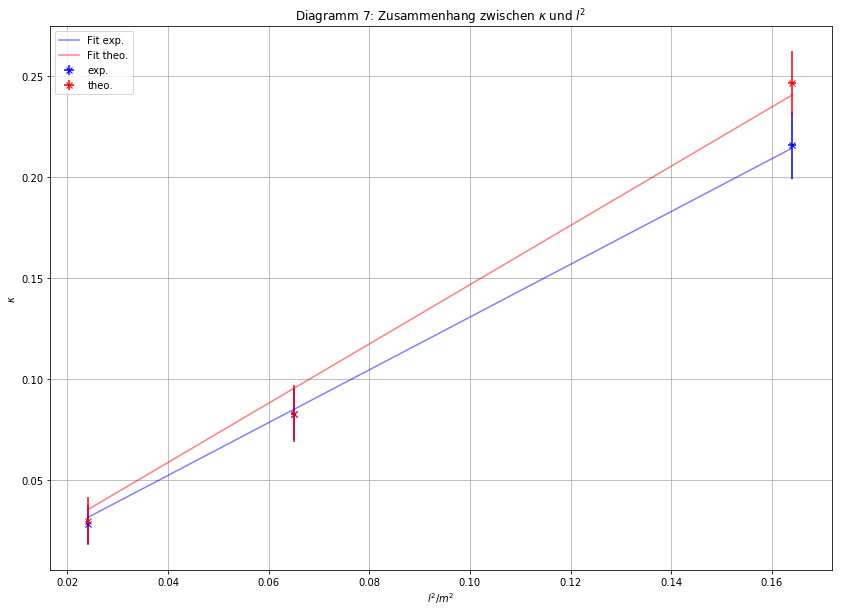

In [11]:
x = array([l[0]**2, l[1]*2*l[0]])
pex, dex = curve_fit(prop, x[0], kappa[0]) #, sigma=kappa[1], absolute_sigma=True)
ptheo, dtheo = curve_fit(prop, x[0], kappatheo[0]) #, sigma=kappatheo[1], absolute_sigma=True)
chi_2(prop, pex, x[0], kappa[0], kappa[1], 'exp.')
chi_2(prop, ptheo, x[0], kappatheo[0], kappatheo[1], 'theo.')

plt.figure(figsize=(14,10))
plt.errorbar(x[0], kappa[0], xerr=x[1], yerr=kappa[1], linestyle='none', color='b', fmt="x", label="exp.")
plt.errorbar(x[0], kappatheo[0], xerr=x[1], yerr=kappatheo[1], linestyle='none', color='r', fmt="x", label="theo.")
plt.plot(x[0], prop(x[0], *pex), color='b', alpha=.5, label='Fit exp.')
plt.plot(x[0], prop(x[0], *ptheo), color='r', alpha=.5, label='Fit theo.')
plt.title(r'Diagramm 7: Zusammenhang zwischen $\kappa$ und $l^2$')
plt.xlabel('$l^2 / m^2$')
plt.ylabel(r'$\kappa$')
plt.legend()
plt.grid()
plt.savefig('figures/plot1-pdf', format='pdf')